In [ ]:
!pip install PyPDF2
!pip install PyMuPDF==1.16.14
!pip install nltk
!pip install docx2python
!pip install aspose-words
!pip install docx2python

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
from docx2python import docx2python
import pathlib
import fitz
import aspose.words as aw
import os

def get_resumes(file_path):
    file_type = pathlib.Path(file_path).suffix
    
    if file_type == '.doc' : 
        doc = aw.Document(file_path)
        file_name = file_path.replace('.doc','')
        doc.save(file_name +".docx")
        os.remove(file_path)

    elif file_type == '.docx':  
      print(file_path)   
      doc_result = docx2python(file_path)
      text = doc_result.text
      return text

    elif file_type == '.pdf': 
      doc = fitz.open(file_path)
      text = ""
      for page in doc:
        text+=page.getText()
      return text

In [204]:
from spacy.matcher import PhraseMatcher
from io import StringIO
from collections import Counter
import pandas as pd
import pandas as pd
import en_core_web_sm
nlp = en_core_web_sm.load()

#function that does phrase matching and builds a candidate profile

def create_profile(file):
    text = get_resumes(os.path.join(path,file)) 
    text = str(text)
    text = text.replace("\\n", "")
    text = text.lower()
    
    #below is the csv where we have all the keywords, you can customize your own

    keyword_dict = pd.read_csv(os.path.join(path,'Skills_keywords.csv'),encoding= 'unicode_escape')
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
  
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Python', None, *python_words)
  
    doc = nlp(text)
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end] # get the matched slice of the doc
        d.append((rule_id, span.text)) 
            
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())

    Subject,Keyword,Count = [],[],[]
    for i,j in Counter(d).items():
      Subject.append(i[0])
      Keyword.append(i[1])
      Count.append(j)

    df = pd.DataFrame(list(zip(Subject,Keyword,Count)),columns =['Subject','Keyword','Count'])
    
    head, sep, tail = file.partition('.')
    df['Candidate Name'] = head
    return df
  

In [217]:
path = "/content/drive/MyDrive/python/"
files = os.listdir(path)

df = pd.DataFrame()

for file in files:
  data = create_profile(file)
  df = df.append(data)

In [207]:
df.head()

,Subject,Keyword,Count,Candidate Name
0,Python,python,10,python_4
1,Python,django,10,python_4
0,Python,python,10,python_5
1,Python,django,6,python_5
0,Python,python,6,python_6


In [218]:
df.to_csv('candidate_profile.csv')

In [210]:
df_new = df['Keyword'].groupby([df['Candidate Name'], df['Subject']]).count().unstack()
df_new.reset_index(inplace = True)
df_new.fillna(0,inplace=True)
new_data = df_new.iloc[:,1:]
new_data.index = df_new['Candidate Name']
print(new_data)

Subject         Python
Candidate Name        
python_1             2
python_10            2
python_2             5
python_3             2
python_4             2
python_5             2
python_6             2
python_7             4
python_8             3
python_9             4


In [211]:
# Make a copy of the original sourcefile
new_data_excel= new_data.copy()

column_list = list(new_data_excel)#create a total score new column by adding the score 

new_data_excel["Total score"] = new_data_excel[column_list].sum(axis=1)
new_data_excel.sort_values(by=['Total score'], inplace=True,ascending=False)
new_data_excel["Rank_pct"] = new_data_excel["Total score"].rank(pct=True)

#create a rank_pct new column based on the total score

In [212]:
format_dict = {'DE':'{0:,.0f}','DL':'{0:,.0f}','NLP':'{0:,.0f}','ML':'{0:,.0f}','JobJD':'{0:,.0f}','Personality':'{0:,.0f}','Python':'{0:,.0f}','R':'{0:,.0f}','Stats':'{0:,.0f}','Total score':'{0:,.0f}', 'Rank_pct': '{:.2%}'}
(new_data_excel
 .style
 .format(format_dict)
 .bar(color='#FFA07A', vmin=100_000, subset=['Total score'], align='zero')
 .bar(color='lightgreen', vmin=0, subset=['Rank_pct'], align='zero')
 .set_caption('Resume ranking score'))

Subject,Python,Total score,Rank_pct
Candidate Name,,,
python_2,5,5,100.00%
python_7,4,4,85.00%
python_9,4,4,85.00%
python_8,3,3,70.00%
python_1,2,2,35.00%
python_10,2,2,35.00%
python_3,2,2,35.00%
python_4,2,2,35.00%
python_5,2,2,35.00%


In [213]:
# highlight the score value in each column.
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
new_data_excel.style.format(format_dict).apply(highlight_max).\
    to_excel('Resume_Score_highest_chart.xlsx', engine='openpyxl')
new_data_excel.style.format(format_dict).apply(highlight_max)

Subject,Python,Total score,Rank_pct
Candidate Name,,,
python_2,5,5,100.00%
python_7,4,4,85.00%
python_9,4,4,85.00%
python_8,3,3,70.00%
python_1,2,2,35.00%
python_10,2,2,35.00%
python_3,2,2,35.00%
python_4,2,2,35.00%
python_5,2,2,35.00%


In [214]:
import seaborn as sns #create “heatmaps

cm = sns.light_palette("green", as_cmap=True)

new_data_excel.style.format(format_dict).background_gradient(cmap=cm).\
    to_excel('Resume_Score_heatmap_chart.xlsx', engine='openpyxl')
new_data_excel.style.format(format_dict).background_gradient(cmap=cm)

Subject,Python,Total score,Rank_pct
Candidate Name,,,
python_2,5,5,100.00%
python_7,4,4,85.00%
python_9,4,4,85.00%
python_8,3,3,70.00%
python_1,2,2,35.00%
python_10,2,2,35.00%
python_3,2,2,35.00%
python_4,2,2,35.00%
python_5,2,2,35.00%


In [215]:
sample2=new_data_excel.to_csv('Resume_Rank_score.csv')

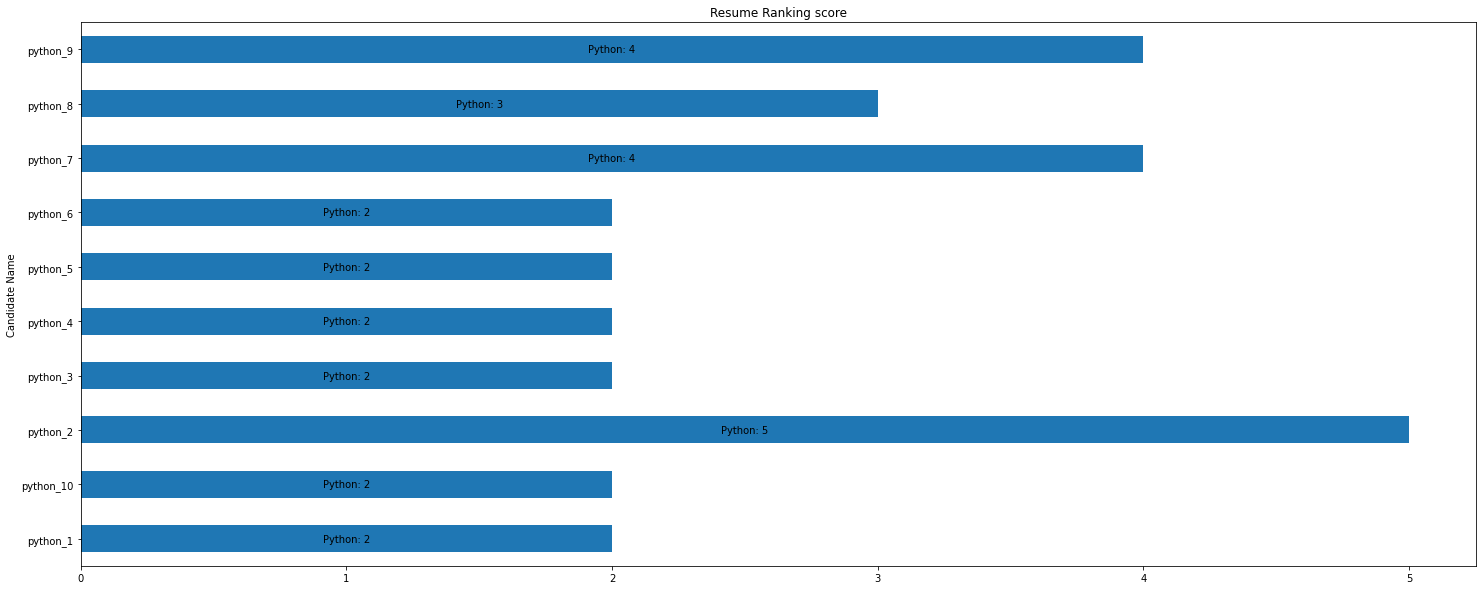

In [216]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume Ranking score", legend=False, figsize=(25,10), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()